# Курсовой проект: "Прогноз цен на недвижимость"

## Задание:
Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

In [1239]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from datetime import datetime as dt

In [1240]:
# Считываем данные датасета для обучения модели
train_df = pd.read_csv("train.csv")
train_df.info() # ознакомимся с признаками датасета, проверим наличие пропусков

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [1241]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


**Описание датасета**
- Id - идентификационный номер квартиры 
- DistrictId - идентификационный номер района 
- Rooms - количество комнат 
- Square - площадь 
- LifeSquare - жилая площадь 
- KitchenSquare - площадь кухни 
- Floor - этаж 
- HouseFloor - количество этажей в доме 
- HouseYear - год постройки дома 
- Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности 
- Social_1, Social_2, Social_3 - социальные показатели местности 
- Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья 
- Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров 
- Price - цена квартиры

In [1242]:
# удалим бесполезные признаки: id - так как не имеет никакого значения для прогноза, Healthcare_1 - так как имеет около 50% пропусков
# значений 
train_df = train_df.drop(columns=['Healthcare_1','Id'])

In [1243]:
# Cоздадим функцию для обработки выбросов
def replace_outliers_and_negatives_with_median(df):
    # Проход по каждому числовому столбцу в DataFrame
    for column in df.select_dtypes(include=[np.number]).columns:
        # Вычисление медианы столбца
        median = df[column].median()

        # Вычисление первого (Q1) и третьего (Q3) квартилей
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)

        # Вычисление межквартильного размаха (IQR)
        IQR = Q3 - Q1

        # Определение границ выбросов
        lower_bound = Q1 - 1.4 * IQR
        upper_bound = Q3 + 1.4 * IQR

        # Определение минимальных и максимальных допустимых значений
        min_value = df[column][df[column] >= lower_bound].min()
        max_value = df[column][df[column] <= upper_bound].max()

        # Замена выбросов на минимальные и максимальные значения
        df[column] = df[column].apply(lambda x: min_value if x < lower_bound else max_value if x > upper_bound else x)
    
    
    return df

In [1244]:
# Заменим все некорректные данные(выбросы)
replace_outliers_and_negatives_with_median(train_df)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
0,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,0,11,B,184966.930730
1,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,1,11,B,300009.450063
2,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,1,3,B,220925.908524
3,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,0,5,B,175616.227217
4,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2,4,B,150226.531644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,3,11,B,196684.316040
9996,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,0,5,A,189050.289571
9997,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,0,0,A,159143.805370
9998,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,2,5,B,181595.339808


In [1245]:
# Подсчет количества нулевых значений в каждом столбце
zero_counts = (train_df == 0.0).sum()
print("Количество нулевых значений в каждом столбце:")
print(zero_counts)

Количество нулевых значений в каждом столбце:
DistrictId         48
Rooms               8
Square              0
LifeSquare          0
KitchenSquare     697
Floor               0
HouseFloor        269
HouseYear           0
Ecology_1         537
Ecology_2           0
Ecology_3           0
Social_1          201
Social_2            0
Social_3         2997
Helthcare_2      4214
Shops_1          2316
Shops_2             0
Price               0
dtype: int64


В колонке KitchenSquare имеется много нулевых значений, заменим их на значения полученные от общей площади. 
Для начала нужно задать минимальный размер кухни в 4 кв. метров, следующим шагом выберем кухни со значением 
большим либо равным 4 и рассчитаем среднюю долю площади кухни от общей площади из отфильтрованных данных

In [1246]:
# Фильтрация строк и вычисление среднего отношения
filtered_df = train_df.loc[train_df.KitchenSquare >= 3]
kitchen_to_square_mean = (filtered_df.KitchenSquare / filtered_df.Square).mean()
kitchen_to_square_mean

0.15566393285016397

In [1247]:
# Замена значений в столбце KitchenSquare для строк, где KitchenSquare < 4
train_df.loc[train_df.KitchenSquare < 4, 'KitchenSquare'] = train_df.loc[train_df.KitchenSquare < 4, 'Square'] * kitchen_to_square_mean
train_df.loc[train_df.KitchenSquare < 4, 'KitchenSquare'] = 4

train_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,49.728100,1.868600,55.686189,35.508342,8.421496,8.498800,12.554900,1984.920100,0.118217,24.687000,5278.395800,3.154200,1.260900,3.786200,209129.660788
std,41.750565,0.772783,17.272932,15.718680,2.687018,5.149976,6.486324,18.270711,0.117137,17.532614,3785.808857,3.581523,1.354553,3.541969,79292.530580
min,0.000000,0.000000,13.784865,0.370619,4.000000,1.000000,0.000000,1937.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,22.769832,6.020354,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,8.000000,7.000000,13.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,45.128803,10.000000,12.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,2.000000,6.000000,249135.462171
max,152.000000,3.000000,99.597011,76.338331,20.000000,23.000000,28.000000,2020.000000,0.437885,74.000000,14892.000000,11.000000,4.000000,11.000000,382297.993189


Видим, что столбец LifeSquare имеет много пропусков, для заполнения пропусков воспользуемся следующим расчетом: 
- найдем среднее значение нежилой площади без учета кухни (т.к. признак KitchenSquare есть в датафрейме и не имеет пропусков )
- заменим пустые значения на то что останется после вычитания из общей площади нежилую площадь(кухня и оставшаяся усредненная нежилая площадь)

In [1248]:
#Расчет доли жилой площади от общей
LifeSquare_mean = (train_df.LifeSquare/train_df.Square).loc[train_df.LifeSquare.notna()].mean()
LifeSquare_mean

0.645869007758359

In [1249]:
train_df.LifeSquare = train_df.LifeSquare.fillna(train_df.Square*LifeSquare_mean)

# Условие для замены значений в столбце LifeSquare
condition = (train_df['LifeSquare'] + train_df['KitchenSquare']) > train_df['Square']

# Замена значений
train_df.loc[condition, 'LifeSquare'] = train_df['Square'] - train_df['KitchenSquare']
train_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,49.728100,1.868600,55.686189,35.225352,8.421496,8.498800,12.554900,1984.920100,0.118217,24.687000,5278.395800,3.154200,1.260900,3.786200,209129.660788
std,41.750565,0.772783,17.272932,13.975637,2.687018,5.149976,6.486324,18.270711,0.117137,17.532614,3785.808857,3.581523,1.354553,3.541969,79292.530580
min,0.000000,0.000000,13.784865,0.370619,4.000000,1.000000,0.000000,1937.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,24.465603,6.020354,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,33.089151,8.000000,7.000000,13.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,44.166108,10.000000,12.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,2.000000,6.000000,249135.462171
max,152.000000,3.000000,99.597011,76.338331,20.000000,23.000000,28.000000,2020.000000,0.437885,74.000000,14892.000000,11.000000,4.000000,11.000000,382297.993189


In [1250]:
# Замена значений в столбце Rooms для строк, где количество комнат < 1 на  минимальное
train_df.loc[train_df['Rooms'] < 1, 'Rooms'] = 1
train_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,49.728100,1.869400,55.686189,35.225352,8.421496,8.498800,12.554900,1984.920100,0.118217,24.687000,5278.395800,3.154200,1.260900,3.786200,209129.660788
std,41.750565,0.771364,17.272932,13.975637,2.687018,5.149976,6.486324,18.270711,0.117137,17.532614,3785.808857,3.581523,1.354553,3.541969,79292.530580
min,0.000000,1.000000,13.784865,0.370619,4.000000,1.000000,0.000000,1937.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,24.465603,6.020354,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,33.089151,8.000000,7.000000,13.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,44.166108,10.000000,12.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,2.000000,6.000000,249135.462171
max,152.000000,3.000000,99.597011,76.338331,20.000000,23.000000,28.000000,2020.000000,0.437885,74.000000,14892.000000,11.000000,4.000000,11.000000,382297.993189


In [1251]:
# Замена значений в столбце HouseFloor для строк, где количество этажей = 0 на значение из признака Floor
train_df.loc[(train_df['HouseFloor'] < 1)| (train_df.Floor > train_df.HouseFloor), 'HouseFloor'] = train_df.Floor
train_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,49.728100,1.869400,55.686189,35.225352,8.421496,8.498800,13.371300,1984.920100,0.118217,24.687000,5278.395800,3.154200,1.260900,3.786200,209129.660788
std,41.750565,0.771364,17.272932,13.975637,2.687018,5.149976,5.758989,18.270711,0.117137,17.532614,3785.808857,3.581523,1.354553,3.541969,79292.530580
min,0.000000,1.000000,13.784865,0.370619,4.000000,1.000000,1.000000,1937.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,24.465603,6.020354,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,33.089151,8.000000,7.000000,14.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,44.166108,10.000000,12.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,2.000000,6.000000,249135.462171
max,152.000000,3.000000,99.597011,76.338331,20.000000,23.000000,28.000000,2020.000000,0.437885,74.000000,14892.000000,11.000000,4.000000,11.000000,382297.993189


In [1252]:
# Повторим процедуру подсчета количества нулевых значений в каждом столбце
zero_counts = (train_df == 0.0).sum()
print("Количество нулевых значений в каждом столбце:")
print(zero_counts)

Количество нулевых значений в каждом столбце:
DistrictId         48
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1         537
Ecology_2           0
Ecology_3           0
Social_1          201
Social_2            0
Social_3         2997
Helthcare_2      4214
Shops_1          2316
Shops_2             0
Price               0
dtype: int64


In [1253]:
# изучим признак HouseYear
train_df.HouseYear.describe()

count    10000.000000
mean      1984.920100
std         18.270711
min       1937.000000
25%       1974.000000
50%       1977.000000
75%       2001.000000
max       2020.000000
Name: HouseYear, dtype: float64

In [1254]:
# Замена значений в столбце HouseYear c года постройки на количество лет
train_df['HouseYear'] = dt.now().year - train_df.HouseYear
train_df.HouseYear.describe()

count    10000.000000
mean        39.079900
std         18.270711
min          4.000000
25%         23.000000
50%         47.000000
75%         50.000000
max         87.000000
Name: HouseYear, dtype: float64

In [1255]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


In [1256]:
# Заменим категориальные признаки на бинарные составляющие 
train_df = pd.get_dummies(train_df, columns=['Ecology_2','Ecology_3','Shops_2'],dtype=int)
train_df.head(5)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Social_3,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,35,2.0,47.981561,29.442751,6.000000,7,9.0,55,0.089040,33,...,5,0,11,184966.930730,0,1,0,1,0,1
1,41,3.0,65.683640,40.049543,8.000000,7,9.0,46,0.000070,46,...,1,1,11,300009.450063,0,1,0,1,0,1
2,53,2.0,44.947953,29.197612,6.996775,8,12.0,56,0.049637,34,...,0,1,3,220925.908524,0,1,0,1,0,1
3,58,2.0,53.352981,44.352981,9.000000,8,17.0,47,0.437885,23,...,3,0,5,175616.227217,0,1,0,1,0,1
4,99,1.0,39.649192,23.776169,7.000000,11,12.0,48,0.012339,35,...,1,2,4,150226.531644,0,1,0,1,0,1


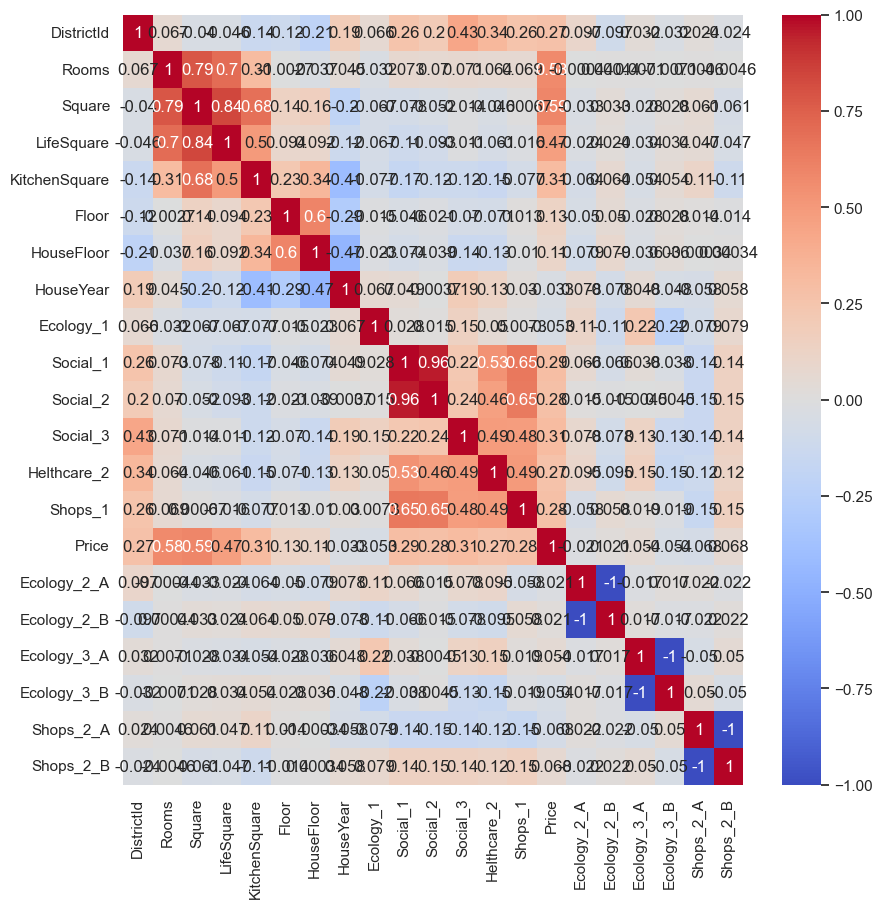

In [1257]:
plt.figure(figsize=(10,10))
sns.heatmap(train_df.corr(), annot=True, cmap='coolwarm')
plt.show()

Из тепловой карты видим, что из всех признаков более менее коррелирующих не так много, и скорее всего построение модели линейной регрессии не принесет желаемого результата, поэтому в дальнейшем будем рассматривать модель RandomForestRegressor

In [1258]:
X,target = train_df.drop(columns=['Price']),train_df.Price

In [1259]:
X = scaler.fit_transform(X)

In [1260]:
X_train,X_test,y_train,y_test = train_test_split(X,target,test_size=0.2,random_state=42)

In [1261]:
# Обучение модели RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, max_depth = 40, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=40, random_state=42)

In [1262]:
# Предсказания на тестовой выборке
y_pred = rf.predict(X_test)

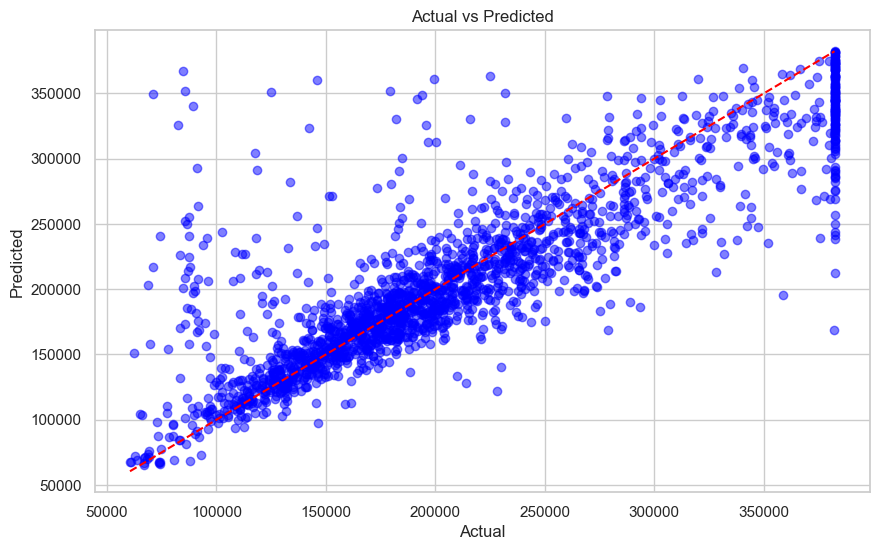

In [1263]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [1264]:
# Оценка модели
r2_sc = r2_score(y_test, y_pred)
print(f'R^2: {r2_sc}')#0.73594

R^2: 0.7359492569605743


Для получения более точного прогноза по цене на недвижимость необходимо глубже изучить механизмы сбора данных и свойств признаков.